# 1. Preprocessing, Naive Bayes, Logistic Regression

## 0. Importing modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer # Lemmatize
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import torch
import torchtext

In [2]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/ande.s/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ande.s/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ande.s/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 1. Loading Datasets

In [3]:
train_dataset, test_dataset = torchtext.datasets.AG_NEWS(root='./data', split = ('train', 'test'))

In [4]:
column_names = ['Class Index', 'Title', 'Description']

train = pd.read_csv('./data/train.csv', header=None, names=column_names )
test = pd.read_csv('./data/test.csv', header=None, names=column_names)

print(f'Training set size: {train.shape}')
print(f'Testing set size: {test.shape}')

Training set size: (120000, 3)
Testing set size: (7600, 3)


In [5]:
train.head(3)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...


In [6]:
test.head(3)

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...


#### Adding labels 

In [7]:
labels = {1: 'World',
          2: 'Sports',
          3: 'Business',
          4: 'Science & Tech'}

train_df = train.copy()
test_df = test.copy()

train_df['labels'] = train_df['Class Index'].map(labels)
test_df['labels'] = test_df['Class Index'].map(labels)

In [8]:
train_df.head(3)

,Class Index,Title,Description,labels
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business


In [9]:
test_df.head(3)

,Class Index,Title,Description,labels
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,Business
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",Science & Tech
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,Science & Tech


## 2. Exploratory Data Analysis(EDA) on Trainset

### 2.1 Checking for class imbalance

In [10]:
train_df.labels.value_counts()

Business          30000
Science & Tech    30000
Sports            30000
World             30000
Name: labels, dtype: int64

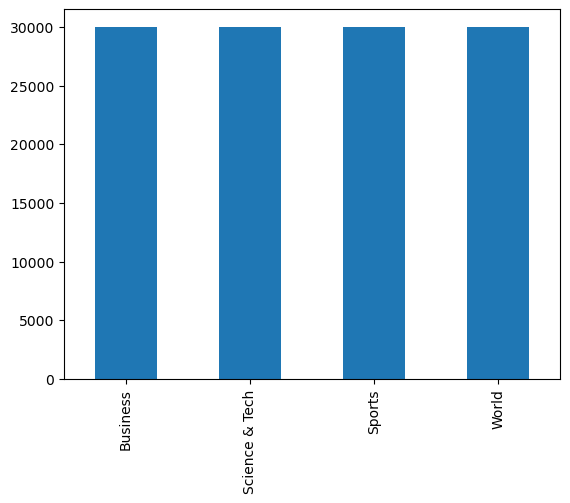

In [11]:
ax = train_df.labels.value_counts().plot(kind='bar')

**All the classes are balanced in the Train set**

### 2.2 Checking for Missing Values

In [12]:
train_df.isnull().sum()

Class Index    0
Title          0
Description    0
labels         0
dtype: int64

**No missing values in the Train set**

###  2.3 Plotting Word Clouds for each label

In [13]:
STOP_WORDS = stopwords.words('english')
stopwords = set(STOP_WORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.remove("not")
stopwords.remove("no")
stopwords.add(" ")

#### 1. World (`Class Index = 1`)

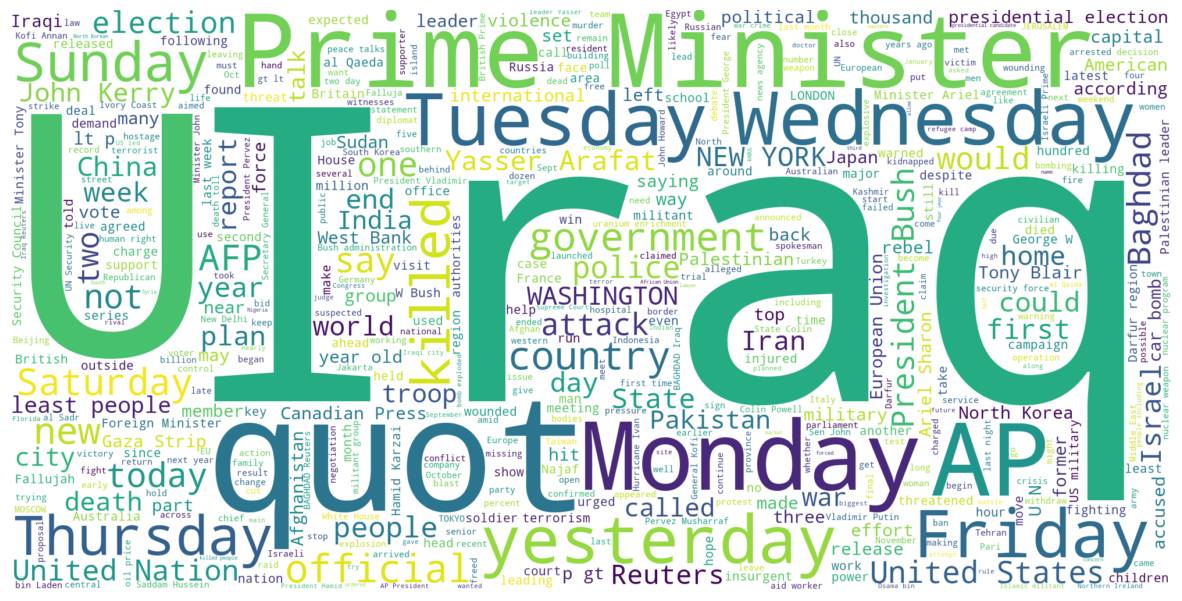

In [14]:
world = train[train['Class Index']==1]['Description']
plt.figure(figsize = (15, 20))
wc = WordCloud(width=2000, height=1000,max_words=500, background_color='White', stopwords=stopwords)
wc.generate(" ".join(world))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2. Sports (`Class Index = 2`)

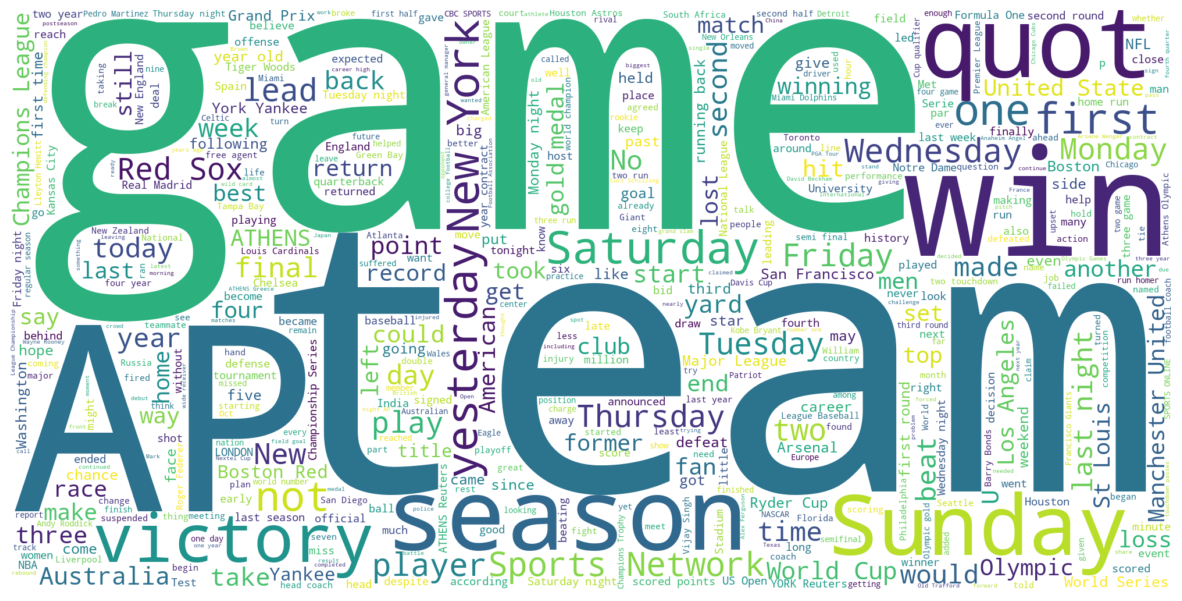

In [15]:
sports = train[train['Class Index']==2]['Description']
plt.figure(figsize = (15, 20))
wc = WordCloud(width=2000, height=1000,max_words=500, background_color='White', stopwords=stopwords)
wc.generate(" ".join(sports))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 3. Business (`Class Index = 3`)

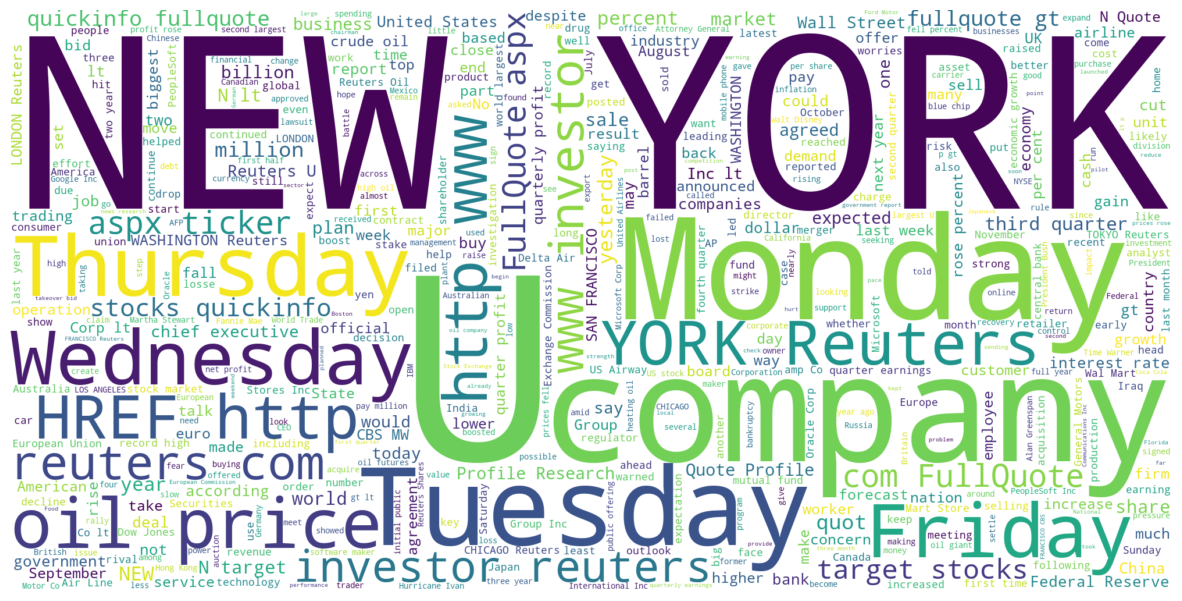

In [16]:
business = train[train['Class Index']==3]['Description']
plt.figure(figsize = (15, 20))
wc = WordCloud(width=2000, height=1000,max_words=500, background_color='White', stopwords=stopwords)
wc.generate(" ".join(business))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 4. Science & Technology (`Class Index = 4`)

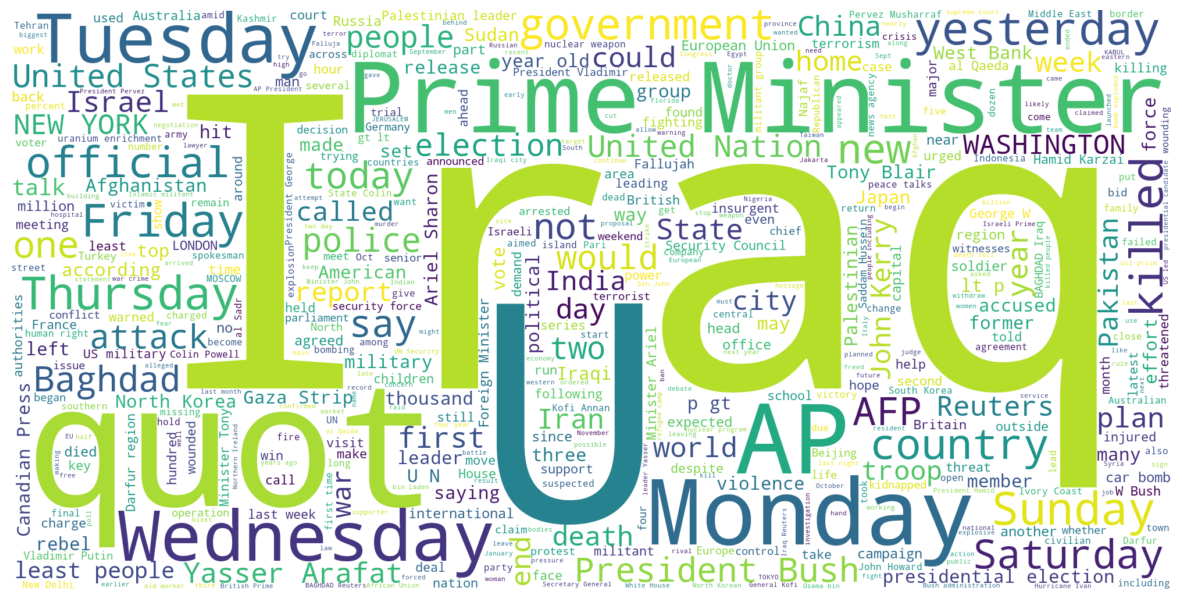

In [17]:
scitech = train[train['Class Index']==4]['Description']
plt.figure(figsize = (15, 20))
wc = WordCloud(width=2000, height=1000,max_words=500, background_color='White', stopwords=stopwords)
wc.generate(" ".join(world))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**Observations:**

## 3. Text Preprocessing

Combining `Title` and `Description` columns into a single `Summary` column

In [18]:
train_df['Summary'] = train_df['Title']+' '+ train_df['Description']
train_df.drop(columns=['Title', 'Description'], inplace=True)
train_df.head()

,Class Index,labels,Summary
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,Business,"Oil prices soar to all-time record, posing new..."


#### Defining Text Processing Functions

1. Expanding Contractions

In [19]:
def expand_contractions(x):   
    
    x = x.replace('%',' percent')\
        .replace('₹',' rupee')\
        .replace('$',' dollar')\
        .replace('€',' euro')\
        .replace(',000,000','m')\
        .replace('000','k')\
        .replace('′',"'")\
        .replace("’","'")\
        .replace("won't","will not")\
        .replace("can't",'can not')\
        .replace("shouldn't","should not")\
        .replace("what's",'"what is"')\
        .replace("that's",'that is')\
        .replace("he's","he is")\
        .replace("she's","she is")\
        .replace("it's","it is")\
        .replace("'ve"," have")\
        .replace("'re"," are")\
        .replace("'ll"," will")\
        .replace("i'm","i am")\
        .replace("n't", " not")
        
        # Add st.-> street
        # Find more contractions
        
    x = re.sub(r'([0-9]+)000000',r'\1m',x)
    x = re.sub(r'([0-9]+)000',r'\1k',x)
    
    return x    

2. Removing URLS

In [20]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

3. Removing HTML tags

In [21]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

4. Tokenization of Data

In [22]:
def word_tokenize(txt):
    tokens = re.findall("[\w']+", txt)
    return tokens

5. Removing Stopwords


In [23]:
def remove_stopwords(lst):
    stop=stopwords
    new_lst=[]
    for i in lst:
        if i not in stop:
            new_lst.append(i)
    return new_lst

6. Removing Extrawords

In [24]:
def remove_extrawords(lst):
    stop=['href','lt','gt','ii','iii','ie','quot','com']   ## This all words are most repeated words as we observed in WordCloud and it does not make any sense
    new_lst=[]
    for i in lst:
        if i not in stop:
            new_lst.append(i)
    return new_lst

7. Removing Punctuations

In [25]:
def remove_punctuations(lst):
    new_lst=[]
    for i in lst:
        for j in  string.punctuation:
            i=i.replace(j,'')
        new_lst.append(i)
    return new_lst

8. Removing numbers

In [26]:
def remove_numbers(lst):
    nodig_lst=[]
    new_lst=[]

    for i in  lst:
        for j in string.digits:
            i=i.replace(j,'')
        nodig_lst.append(i)
    for i in  nodig_lst:
        if  i!='':
            new_lst.append(i)
    return new_lst

9. Lemmatization with `WordNetlemmatizer()`

In [27]:
lemmatizer = WordNetLemmatizer()
def lemmatization(lst):
    new_lst=[]
    for i in lst:
        i=lemmatizer.lemmatize(i)
        new_lst.append(i)
    return new_lst

### Applying the text pre-processing functions

In [28]:
train_df['Summary'] = train_df['Summary'].fillna("")\
                                         .str.lower()\
                                         .apply(expand_contractions)\
                                         .apply(remove_urls)\
                                         .apply(remove_html)\
                                         .apply(word_tokenize)\
                                         .apply(remove_stopwords)\
                                         .apply(remove_extrawords)\
                                         .apply(remove_punctuations)\
                                         .apply(remove_numbers)\
                                         .apply(lemmatization)

In [29]:
train_df.isnull().sum()

Class Index    0
labels         0
Summary        0
dtype: int64

In [30]:
train_df.head()

,Class Index,labels,Summary
0,3,Business,"[wall, st, bear, claw, back, black, reuters, r..."
1,3,Business,"[carlyle, look, toward, commercial, aerospace,..."
2,3,Business,"[oil, economy, cloud, stock, outlook, reuters,..."
3,3,Business,"[iraq, halt, oil, export, main, southern, pipe..."
4,3,Business,"[oil, price, soar, time, record, posing, new, ..."


### 3.3 Applying the same pre-processing steps on the Test set

In [31]:
test_df.labels.value_counts()

Business          1900
Science & Tech    1900
Sports            1900
World             1900
Name: labels, dtype: int64

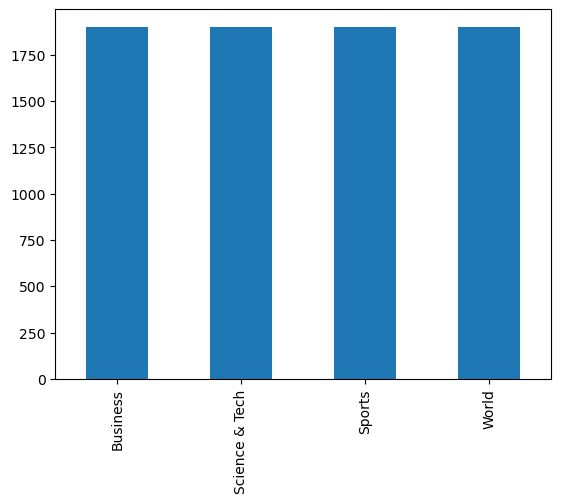

In [32]:
ax = test_df.labels.value_counts().plot(kind='bar')

**Test set is also balanced**

#### Combining `Title` and `Description` columns into a single `Summary` column

In [33]:
test_df['Summary'] = test_df['Title']+' '+ test_df['Description']
test_df.drop(columns=['Title', 'Description'], inplace=True)

In [34]:
test_df['Summary'] = test_df['Summary'].fillna("")\
                                       .str.lower()\
                                       .apply(expand_contractions)\
                                       .apply(remove_urls)\
                                       .apply(remove_html)\
                                       .apply(word_tokenize)\
                                       .apply(remove_stopwords)\
                                       .apply(remove_extrawords)\
                                       .apply(remove_punctuations)\
                                       .apply(remove_numbers)\
                                       .apply(lemmatization)

In [35]:
test_df.isnull().sum()

Class Index    0
labels         0
Summary        0
dtype: int64

In [36]:
test_df.head()

,Class Index,labels,Summary
0,3,Business,"[fear, n, pension, talk, union, representing, ..."
1,4,Science & Tech,"[race, second, private, team, set, launch, dat..."
2,4,Science & Tech,"[ky, company, win, grant, study, peptide, ap, ..."
3,4,Science & Tech,"[prediction, unit, help, forecast, wildfire, a..."
4,4,Science & Tech,"[calif, aim, limit, farm, related, smog, ap, a..."


## 4. Splitting into Train, Test and Valiation sets

In [37]:
train_df.drop(columns=['labels'], inplace=True)
test_df.drop(columns=['labels'], inplace=True)

In [38]:
X_train = train_df[['Summary']]
y_train = train_df[['Class Index']]

X_train.shape, y_train.shape

((120000, 1), (120000, 1))

In [39]:
X_test, X_val, y_test, y_val = train_test_split(test_df['Summary'], test_df['Class Index'], test_size=0.5, random_state=43, shuffle = True, stratify = test_df['Class Index'])

In [40]:
X_test.shape, y_test.shape

((3800,), (3800,))

In [41]:
y_test.value_counts()

4    950
3    950
2    950
1    950
Name: Class Index, dtype: int64

In [42]:
X_val.shape, y_val.shape

((3800,), (3800,))

In [43]:
y_val.value_counts()

2    950
1    950
4    950
3    950
Name: Class Index, dtype: int64

In [44]:
X_test.iloc[0]

['symantec',
 'warns',
 'weakness',
 'firewall',
 'gateway',
 'product',
 'security',
 'specialist',
 'symantec',
 'admitted',
 'number',
 'vulnerability',
 'firewall',
 'gateway',
 'product',
 'weakness',
 'make',
 'liable',
 'denial',
 'service',
 'attack',
 'compromise']

## 5. Models

In [45]:
word_lists = X_train.Summary.tolist()
tokens = set()
for word_list in word_lists:
    for word in word_list:
        tokens.add(word)
len(tokens)

55898

Ignoring tokens that occur in more than 75% of the documents

#### Tf-idf Vectorization

In [46]:
vectorizer_tfidf = TfidfVectorizer(tokenizer=None, stop_words=None, max_df=0.75, max_features=2000, lowercase=False, ngram_range=(1,2))

train_vectors = vectorizer_tfidf.fit_transform(X_train['Summary'].astype('str'))
test_vectors = vectorizer_tfidf.transform(X_test.astype('str'))
val_vectors = vectorizer_tfidf.transform(X_val.astype('str'))

In [47]:
features = vectorizer_tfidf.get_feature_names_out()
features[:20]

array(['able', 'abu', 'abuse', 'access', 'according', 'account',
       'accounting', 'accused', 'acquire', 'acquisition', 'across', 'act',
       'action', 'activity', 'ad', 'add', 'added', 'administration',
       'advance', 'advanced'], dtype=object)

In [48]:
len(features)

2000

In [49]:
vectorizer_tfidf.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': False,
 'max_df': 0.75,
 'max_features': 2000,
 'min_df': 1,
 'ngram_range': (1, 2),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [50]:
train_df = pd.DataFrame(train_vectors.toarray(),columns=vectorizer_tfidf.get_feature_names_out())
train_df = pd.concat([train_df,y_train['Class Index'].reset_index(drop = True)],axis = 1)

train_df

,able,abu,abuse,access,according,account,accounting,accused,acquire,acquisition,...,yesterday,yet,york,york reuters,york yankee,young,yukos,zealand,zone,Class Index
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
119996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
119997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.218315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
119998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [51]:
y_test

2408    4
1101    3
2315    2
1384    2
2755    3
       ..
5020    3
4067    1
2411    2
3649    1
3567    4
Name: Class Index, Length: 3800, dtype: int64

In [52]:
test_df = pd.DataFrame(test_vectors.toarray(),columns=vectorizer_tfidf.get_feature_names_out())
test_df = pd.concat([test_df, y_test.reset_index(drop = True)],axis = 1)

test_df

,able,abu,abuse,access,according,account,accounting,accused,acquire,acquisition,...,yesterday,yet,york,york reuters,york yankee,young,yukos,zealand,zone,Class Index
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,0.0,0.0,0.0,0.0,0.234256,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3796,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3797,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3798,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [53]:
val_df = pd.DataFrame(val_vectors.toarray(),columns=vectorizer_tfidf.get_feature_names_out())
val_df = pd.concat([val_df, y_val.reset_index(drop = True)],axis = 1)

val_df

,able,abu,abuse,access,according,account,accounting,accused,acquire,acquisition,...,yesterday,yet,york,york reuters,york yankee,young,yukos,zealand,zone,Class Index
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.183431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3796,0.0,0.0,0.0,0.0,0.242501,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3797,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3798,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [54]:
X_train = train_df.drop(['Class Index'],axis = 'columns')
y_train = train_df['Class Index']

X_train.shape, y_train.shape

((120000, 2000), (120000,))

In [55]:
X_test = test_df.drop(['Class Index'],axis = 'columns')
y_test = test_df['Class Index']

X_test.shape, y_test.shape

((3800, 2000), (3800,))

In [56]:
X_val = val_df.drop(['Class Index'],axis = 'columns')
y_val = val_df['Class Index']

X_val.shape, y_val.shape

((3800, 2000), (3800,))

In [57]:
def confusion_mat(color, y_actual, y_pred):
    cof=confusion_matrix(y_actual, y_pred)
    cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['World','Sports','Business','Science'],yticklabels=['World','Sports','Business','Science']);
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");

# 2. Multinomial Naive Bayes

In [58]:
from sklearn.naive_bayes import MultinomialNB

In [59]:
model_MNB = MultinomialNB()
model_MNB.fit(X_train, y_train)
y_hat_test = model_MNB.predict(X_test)

print("first 20 actual labels")
print(y_test.tolist()[:20])
print("first 20 predicted labels")
print(y_hat_test.tolist()[:20])

first 20 actual labels
[4, 3, 2, 2, 3, 4, 2, 4, 2, 3, 3, 2, 4, 3, 1, 3, 4, 4, 1, 2]
first 20 predicted labels
[4, 4, 2, 2, 3, 4, 2, 3, 2, 3, 3, 2, 4, 1, 1, 3, 4, 4, 1, 2]


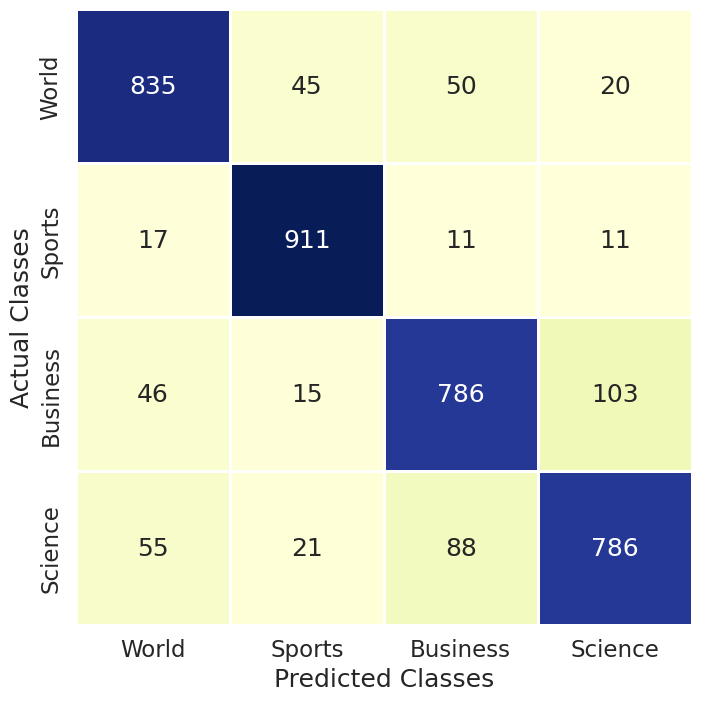

In [60]:
confusion_mat('YlGnBu', y_test, y_hat_test)

In [62]:
print('\nClassification Report\n')
print(classification_report(y_test, y_hat_test))


Classification Report

              precision    recall  f1-score   support

           1       0.88      0.88      0.88       950
           2       0.92      0.96      0.94       950
           3       0.84      0.83      0.83       950
           4       0.85      0.83      0.84       950

    accuracy                           0.87      3800
   macro avg       0.87      0.87      0.87      3800
weighted avg       0.87      0.87      0.87      3800



In [63]:
a1 = round(accuracy_score(y_test, y_hat_test)*100,4)
a2 = round(100-accuracy_score(y_test, y_hat_test)*100,4)
print('Accuracy:',a1)
print('Error:',a2)

Accuracy: 87.3158
Error: 12.6842


# 3. Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression

In [65]:
%%time

lr_model = LogisticRegression(penalty='l2',solver= 'newton-cg',multi_class= 'multinomial')

lr_model.fit(X_train,y_train)
y_hat_test = lr_model.predict(X_test)

CPU times: user 4min 50s, sys: 58.1 s, total: 5min 49s
Wall time: 31 s


In [66]:
print("first 20 actual labels")
print(y_test.tolist()[:20])
print("first 20 predicted labels")
print(y_hat_test.tolist()[:20])

first 20 actual labels
[4, 3, 2, 2, 3, 4, 2, 4, 2, 3, 3, 2, 4, 3, 1, 3, 4, 4, 1, 2]
first 20 predicted labels
[4, 4, 2, 2, 3, 4, 2, 4, 2, 3, 3, 2, 4, 1, 1, 3, 4, 4, 1, 2]


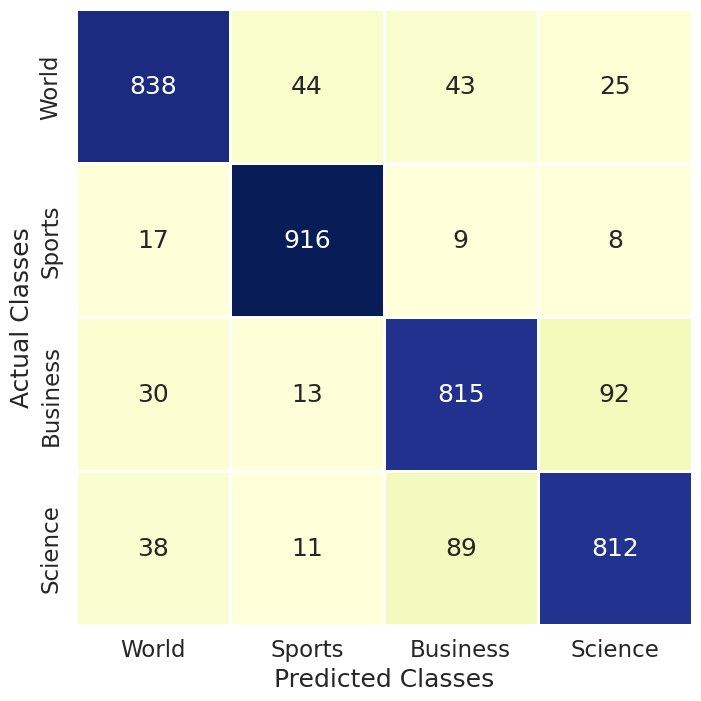

In [67]:
confusion_mat('YlGnBu', y_test, y_hat_test)

In [68]:
print('\nClassification Report\n')
print(classification_report(y_test, y_hat_test))


Classification Report

              precision    recall  f1-score   support

           1       0.91      0.88      0.89       950
           2       0.93      0.96      0.95       950
           3       0.85      0.86      0.86       950
           4       0.87      0.85      0.86       950

    accuracy                           0.89      3800
   macro avg       0.89      0.89      0.89      3800
weighted avg       0.89      0.89      0.89      3800



In [69]:
a1 = round(accuracy_score(y_test, y_hat_test)*100,4)
a2 = round(100-accuracy_score(y_test, y_hat_test)*100,4)
print('Accuracy:',a1)
print('Error:',a2)

Accuracy: 88.9737
Error: 11.0263
